In [42]:
from pathlib import Path
from dataclasses import dataclass
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing import Any
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
%load_ext autoreload
%autoreload 2


@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"


config = Config()

sys.path.append(str(config.REPO_ROOT))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from python.src.preprocess import (
    preprocess_bike_data,
)

df_bike = pd.read_csv(config.data_dir / "bike+sharing+dataset" / "day.csv")
df_bike_processed = preprocess_bike_data(df=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]

In [80]:
from python.src.utils import AccumulatedLocalEffects, PartialDependence

In [89]:
df_bike_processed.head()


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


In [73]:
# 必要な特徴量を選択
features_of_interest = [
    "days_since_2011",
    "temp",
    "season",
    "windspeed",
    "hum",
]  # Rのコードに合わせる
# X = df_bike_processed[features_of_interest]
# y = df_bike_processed["cnt"]
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# カテゴリ変数と数値変数を分離
categorical_features = ["season"]
numerical_features = ["days_since_2011", "temp", "windspeed", "hum"]
# OneHotEncoderを適用
encoded_features = enc.fit_transform(df_bike_processed[categorical_features])
encoded_df = pd.DataFrame(
    encoded_features, columns=enc.get_feature_names_out(categorical_features)
)

# 数値変数と結合
X = pd.concat([df_bike_processed[numerical_features], encoded_df], axis=1)
y = df_bike_processed["cnt"]

X_sampled = X.sample(n=300, random_state=42)
# 決定木の構築
ct = RandomForestRegressor(random_state=42)
ct.fit(X, y)

RandomForestRegressor(random_state=42)

In [74]:
X_sampled

,days_since_2011,temp,windspeed,hum,season_FALL,season_SPRING,season_SUMMER,season_WINTER
703,703,14.364151,11.666643,73.3750,1.0,0.0,0.0,0.0
33,33,0.786979,18.609384,43.7826,0.0,0.0,0.0,1.0
300,300,7.549151,15.375093,58.5833,1.0,0.0,0.0,0.0
456,456,12.014151,11.541889,67.6250,0.0,1.0,0.0,0.0
633,633,17.850000,15.833507,57.0000,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
75,75,11.505000,14.041793,60.2917,0.0,0.0,0.0,1.0
377,377,4.885849,25.333236,50.7500,0.0,0.0,0.0,1.0
277,277,17.301651,11.875750,64.7917,1.0,0.0,0.0,0.0
68,68,10.287277,17.545759,0.0000,0.0,0.0,0.0,1.0


In [75]:
test_acl = AccumulatedLocalEffects(
    model=ct,
    X=X_sampled,
    var_names=["temp", "hum", "windspeed"],
    pred_type="regression",
)
df = test_acl.accumulated_local_effects(2)

<Axes: xlabel='x', ylabel='ale'>

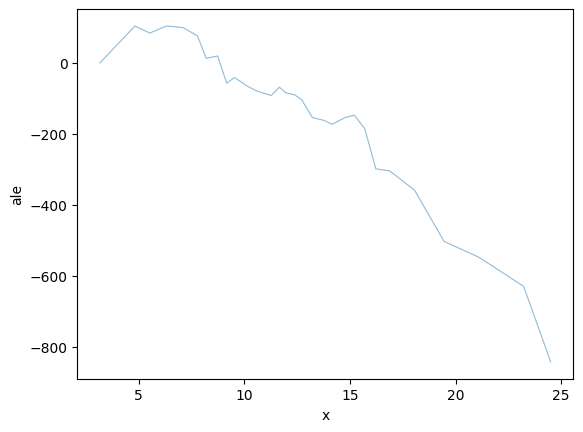

In [76]:
fig, ax = plt.subplots()
sns.lineplot(
    x="x",  # Correct: string representing column name
    y="ale",  # Correct: string representing column name
    # units="instance",  # Correct: string representing column name
    data=df,  # Crucial: provide the DataFrame
    lw=0.8,
    alpha=0.5,
    estimator=None,
    zorder=1,
    ax=ax,
)

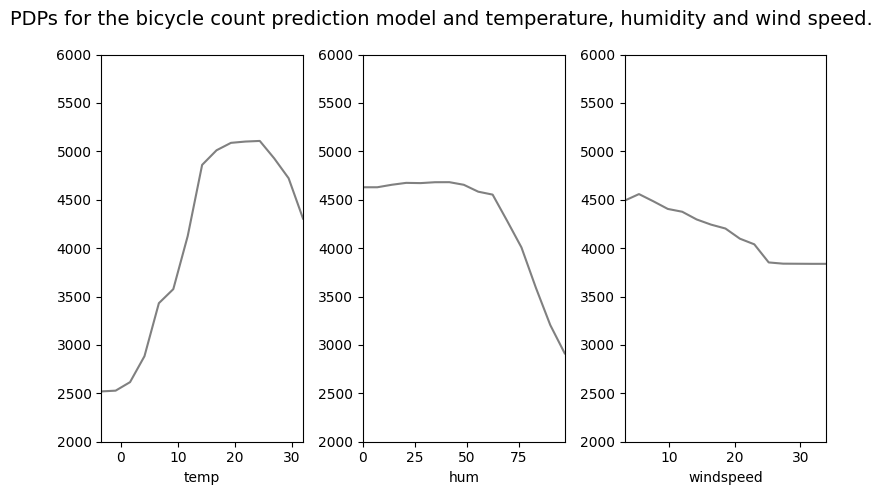

In [84]:
# # Train a RandomForestRegressor model
# model = RandomForestRegressor(random_state=0)  # random_state for reproducibility
# model.fit(X, y)
pdp = PartialDependence(
    ct, X_sampled, ["temp", "hum", "windspeed"], pred_type="regression"
)

fig, axes = plt.subplots(1, 3, figsize=(8, 5))

# Set y-axis limits directly
y_min = -500
y_max = 7000

# features = ["temp", "hum", "windspeed"]
# X = df_bike_processed[features]
# y = df_bike_processed["cnt"]
# Create the PDP plots
for i, (feature, ax) in enumerate(zip(["temp", "hum", "windspeed"], axes.ravel())):
    df_pd = pdp.partial_dependence(feature, n_grid=15)
    x_min, x_max = df_pd[feature].min(), df_pd[feature].max()
    ax.set_ylim(2000, 6000)
    ax.set_xlabel(feature)
    ax.set_xlim(x_min, x_max)
    ax.plot(df_pd[feature], df_pd["avg_pred"], color="gray")

fig.suptitle(
    "PDPs for the bicycle count prediction model and temperature, humidity and wind speed.",
    fontsize=14,
)
plt.tight_layout()
plt.show()

In [86]:
X_sampled

,days_since_2011,temp,windspeed,hum,season_FALL,season_SPRING,season_SUMMER,season_WINTER
703,703,14.364151,11.666643,73.3750,1.0,0.0,0.0,0.0
33,33,0.786979,18.609384,43.7826,0.0,0.0,0.0,1.0
300,300,7.549151,15.375093,58.5833,1.0,0.0,0.0,0.0
456,456,12.014151,11.541889,67.6250,0.0,1.0,0.0,0.0
633,633,17.850000,15.833507,57.0000,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
75,75,11.505000,14.041793,60.2917,0.0,0.0,0.0,1.0
377,377,4.885849,25.333236,50.7500,0.0,0.0,0.0,1.0
277,277,17.301651,11.875750,64.7917,1.0,0.0,0.0,0.0
68,68,10.287277,17.545759,0.0000,0.0,0.0,0.0,1.0


In [87]:
df_bike

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,days_since_2011
0,1,2011-01-01,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,28.363250,80.5833,10.749882,331,654,985,0
1,2,2011-01-02,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,28.027126,69.6087,16.652113,131,670,801,1
2,3,2011-01-03,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,22.439770,43.7273,16.636703,120,1229,1349,2
3,4,2011-01-04,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,23.212148,59.0435,10.739832,108,1454,1562,3
4,5,2011-01-05,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,23.795180,43.6957,12.522300,82,1518,1600,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,WINTER,2012,DEC,NO HOLIDAY,THU,WORKING DAY,MISTY,3.945849,23.705828,65.2917,23.458911,247,1867,2114,726
727,728,2012-12-28,WINTER,2012,DEC,NO HOLIDAY,FRI,WORKING DAY,MISTY,3.906651,24.671564,59.0000,10.416557,644,2451,3095,727
728,729,2012-12-29,WINTER,2012,DEC,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,3.906651,24.241600,75.2917,8.333661,159,1182,1341,728
729,730,2012-12-30,WINTER,2012,DEC,NO HOLIDAY,SUN,NO WORKING DAY,GOOD,4.024151,23.877800,48.3333,23.500518,364,1432,1796,729


In [90]:
from python.src.preprocess import (
    preprocess_rfcc,
)

df_rfcc = pd.read_csv(config.data_dir / "risk_factors_cervical_cancer.csv")
df_rfcc_preprocessed = preprocess_rfcc(df=df_rfcc)
assert df_rfcc.shape[0] == df_rfcc_preprocessed.shape[0]

In [91]:
X = df_rfcc_preprocessed.drop("Biopsy", axis=1)
y = df_rfcc_preprocessed["Biopsy"].map(
    {"Healthy": 0, "Cancer": 1}
)  # Replace with your actual target
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=43
# )
df_rfcc_preprocessed_sampled = df_rfcc_preprocessed.sample(n=300, random_state=42)
df_rfcc_preprocessed_sampled_X = df_rfcc_preprocessed_sampled.drop("Biopsy", axis=1)
rf_model = RandomForestClassifier(random_state=43)  # random_stateで再現性を確保
rf_model.fit(X, y)

RandomForestClassifier(random_state=43)

<Axes: xlabel='x', ylabel='ale'>

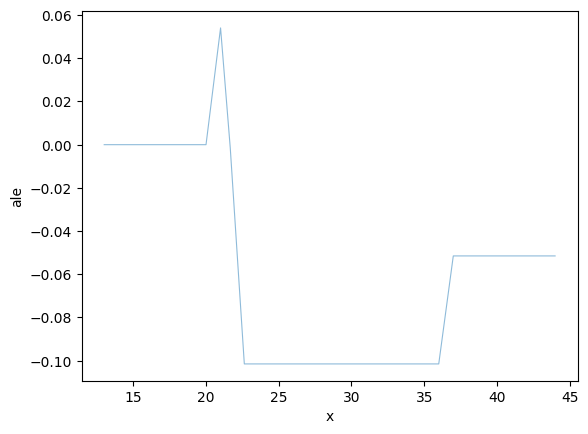

In [104]:
aci = AccumulatedLocalEffects(
    model=rf_model,
    X=df_rfcc_preprocessed_sampled_X,
    var_names=["Age", "Hormonal Contraceptives (years)'"],
    pred_type="classification",
)
df = aci.accumulated_local_effects(0)
fig, ax = plt.subplots()
sns.lineplot(
    x="x",  # Correct: string representing column name
    y="ale",  # Correct: string representing column name
    # units="instance",  # Correct: string representing column name
    data=df,  # Crucial: provide the DataFrame
    lw=0.8,
    alpha=0.5,
    estimator=None,
    zorder=1,
    ax=ax,
)

In [105]:
df_rfcc_preprocessed_sampled_X.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'],
      dtype='object')

<Axes: xlabel='x', ylabel='ale'>

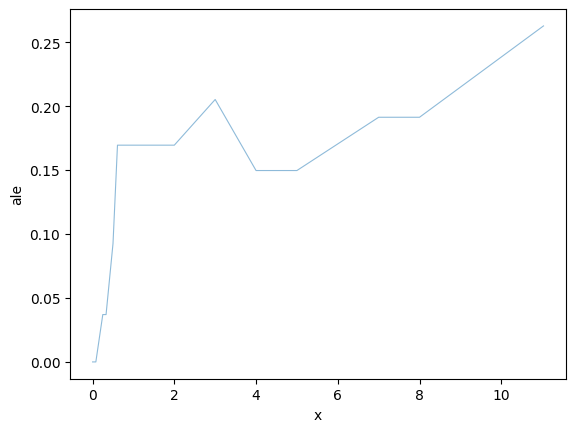

In [109]:
aci = AccumulatedLocalEffects(
    model=rf_model,
    X=df_rfcc_preprocessed_sampled_X,
    var_names=["Age", "Hormonal Contraceptives (years)'"],
    pred_type="classification",
)
df = aci.accumulated_local_effects(7)
fig, ax = plt.subplots()
sns.lineplot(
    x="x",  # Correct: string representing column name
    y="ale",  # Correct: string representing column name
    # units="instance",  # Correct: string representing column name
    data=df,  # Crucial: provide the DataFrame
    lw=0.8,
    alpha=0.5,
    estimator=None,
    zorder=1,
    ax=ax,
)

In [98]:
df_rfcc_preprocessed_sampled_X["Hormonal Contraceptives (years)"].max()

np.float64(22.0)